In [1]:
# Dependencies and setup
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.exc import ProgrammingError
import warnings
from create_db import engine
import datetime

/Users/gabprado/Documents/BootCamp_GIT/projects/Project1---Team_BigBend/traffic_incident_apis/data.austin/create_db.py:16: UserWarning: Could not create database team_big_bend. Database team_big_bend may already exist.
  warnings.warn(


# Traffic Incident Data
---

In [2]:
#Fetch incidents from the incidents table in the MySQL db.
DATABASE = "team_big_bend"
engine.execute(f"USE {DATABASE}")
get_incidents = engine.execute("Select * from incidents")

In [3]:
#Put query results and columns into a data frame and display results
incidents = pd.DataFrame(get_incidents.fetchall())
incidents.columns = get_incidents.keys()
incidents

,index,ReportID,IncidentDesc,Address,IncidentDate,Street,RecordDate
0,108,F594216AB73D45120DC603E926DA86C1AE918428_15089...,Crash Urgent,N LAMAR BLVD & W ST JOHNS AVE,2017-10-25T12:15:00.000Z,LAMAR,2017-10-25
1,128,BE2608CD9B0E64302FCB6170D889D6A11E1EBDD7_15089...,Crash Urgent,N LAMAR BLVD & W BRAKER LN,2017-10-25T13:40:00.000Z,LAMAR,2017-10-25
2,148,B37376966AC6D8C371B3A1D74862360FE5710E1C_15089...,Crash Service,2108 S LAMAR BLVD,2017-10-25T15:00:00.000Z,LAMAR,2017-10-25
3,149,869655D8ABDC71EBDF8A999DE0B7E85B1FA69D28_15089...,Crash Service,12430 N LAMAR BLVD,2017-10-25T15:00:00.000Z,LAMAR,2017-10-25
4,183,C71CC62930CF523FCF54EFD029485F66FA5D839A_15089...,Crash Service,9504 N LAMAR BLVD,2017-10-25T16:45:00.000Z,LAMAR,2017-10-25
...,...,...,...,...,...,...,...
5721,158164,6EF79C21DD35EA505E11D0C6673B8A2588FA650B_15793...,Traffic Hazard,S LAMAR BLVD & BARTON SPRINGS RD,2020-01-17T23:15:04.000Z,LAMAR,2020-01-17
5722,158258,D1D904BDB4FAEC931ACB49890B51B0657C0BB751_15793...,Crash Urgent,8630 N LAMAR BLVD,2020-01-18T12:05:04.000Z,LAMAR,2020-01-18
5723,158312,891F22C19BE6AD30B70EE6881F96E1BC678AC17F_15793...,Traffic Hazard,W RUNDBERG LN & N LAMAR BLVD,2020-01-18T19:55:03.000Z,LAMAR,2020-01-18
5724,158321,6639A80483FE6E8AB03511DDBCCCAAB4A18BAD32_15793...,Crash Urgent,N LAMAR BLVD & W 29TH ST,2020-01-18T21:00:06.000Z,LAMAR,2020-01-18


In [4]:
#Create a data frame that contains the daily incident count for the data set and display the results
incident_daily = pd.DataFrame(incidents.groupby("RecordDate")["ReportID"].count()) \
                .rename(columns={"ReportID" : "Incident Count"})
incident_daily


,Incident Count
RecordDate,
2017-10-25,11
2017-10-26,5
2017-10-27,8
2017-10-28,5
2017-10-29,2
...,...
2020-01-14,11
2020-01-15,11
2020-01-16,8


---
# Travel Data
---

In [179]:
bluetooth_raw = []
r = requests.get("https://data.austintexas.gov/resource/x44q-icha.json?$where=origin_reader_identifier like '%amar_%'"
                 , params = {
#                "$limit": 10,
                "$limit": 50000000,
                "$offset": 0
                
                })
if r.status_code == 200:     
        bluetooth_raw = r.json()
else:
    print("***** IT IS BROKEN *****")
    print(r.status_code)

In [180]:
travel_data = [{
    "ID": rec["record_id"],
    "Start": rec["origin_reader_identifier"].upper(),
    "Ending": rec["destination_reader_identifier"].upper(),
    "TravelTime": int(rec["travel_time_seconds"]),
    "MPH": int(rec["speed_miles_per_hour"]),
    "StartTime": rec["start_time"],
    "EndTime": rec["end_time"]
} for rec in bluetooth_raw]

In [181]:
tvld = pd.DataFrame(travel_data)

In [184]:
tvld.shape

(28600162, 7)

In [185]:
tvld["hwy"] = tvld["Ending"].str.extract("(LAMAR)", expand = True)
tvld["RecordDate"] = tvld["StartTime"].str.extract("(\d+-\d+-\d+)", expand = True)
tvld_filtered_df = tvld[tvld.hwy.notnull()]

In [186]:
travel_by_date = pd.DataFrame(tvld_filtered_df.groupby("RecordDate").agg({
                                 "ID" : "count",
                                 "TravelTime" : "mean",
                                 "MPH" : "mean"
                                })).rename(columns={
                                                        "ID" : "Vehicle Count",
                                                        "TravelTime" : "AVG Travel Time",
                                                        "MPH" : "AVG Speed (mph)"
                                                    })
travel_by_date

,Vehicle Count,AVG Travel Time,AVG Speed (mph)
RecordDate,,,
2015-12-31,15,449.866667,18.600000
2016-01-01,14189,124.319543,26.506237
2016-01-02,14717,138.959571,25.424407
2016-01-03,12244,123.206713,26.326446
2016-01-04,18615,136.857695,24.433145
...,...,...,...
2019-11-02,16667,144.774945,24.796004
2019-11-03,1,138.000000,17.000000
2019-11-04,18343,154.946792,22.710680


---
# Traffic Incidents vs Vehicle Speed
---

In [228]:
main_df = travel_by_date.join(incident_date).fillna(0)
main_df["Incident Count"] = main_df["Incident Count"].astype("int64")
main_df.head(50)

,Vehicle Count,AVG Travel Time,AVG Speed (mph),Incident Count
RecordDate,,,,
2015-12-31,15,449.866667,18.600000,0
2016-01-01,14189,124.319543,26.506237,0
2016-01-02,14717,138.959571,25.424407,0
2016-01-03,12244,123.206713,26.326446,0
2016-01-04,18615,136.857695,24.433145,0
2016-01-05,20403,147.962800,24.440523,0
2016-01-06,22494,168.598960,23.199520,0
2016-01-07,19434,146.367037,23.085109,0
2016-01-08,20884,140.226106,23.251915,0


In [229]:
incident_impact = pd.DataFrame(main_df.groupby("Incident Count").agg({
                                 "Vehicle Count" : "sum",
                                 "AVG Travel Time" : "mean",
                                 "AVG Speed (mph)" : "mean"
                                }))

In [230]:
incident_impact = incident_impact[1:(len(incident_impact)-1)]

In [232]:
incident_impact["Travel_Impact"] =  (((incident_impact["AVG Travel Time"] - incident_impact["AVG Travel Time"].mean()) \
                                     / incident_impact["AVG Travel Time"].mean()) * 100)#.map("{0:.2f}%".format)

incident_impact["Speed_Impact"] =  (((incident_impact["AVG Speed (mph)"] - incident_impact["AVG Speed (mph)"].mean()) \
                                     / incident_impact["AVG Speed (mph)"].mean()) * 100)#.map("{0:.2f}%".format)

In [233]:
incident_impact

,Vehicle Count,AVG Travel Time,AVG Speed (mph),Travel_Impact,Speed_Impact
Incident Count,,,,,
1,254958,144.682082,25.006088,-5.922242,5.052433
2,431227,147.110610,25.140473,-4.343122,5.616994
3,690954,146.416049,25.055641,-4.794752,5.260610
4,984311,148.769861,24.714089,-3.264214,3.825724
5,1282116,149.938811,24.363522,-2.504119,2.352968
6,1340411,154.083408,23.797450,0.190855,-0.025144
7,1301171,150.372386,24.284899,-2.222192,2.022664
8,1133547,150.801633,24.150004,-1.943079,1.455960
9,1287839,153.464814,23.877811,-0.211378,0.312459


In [238]:
impact_smry = incident_impact.reset_index()
impact_smry

,Incident Count,Vehicle Count,AVG Travel Time,AVG Speed (mph),Travel_Impact,Speed_Impact
0,1,254958,144.682082,25.006088,-5.922242,5.052433
1,2,431227,147.110610,25.140473,-4.343122,5.616994
2,3,690954,146.416049,25.055641,-4.794752,5.260610
3,4,984311,148.769861,24.714089,-3.264214,3.825724
4,5,1282116,149.938811,24.363522,-2.504119,2.352968
5,6,1340411,154.083408,23.797450,0.190855,-0.025144
6,7,1301171,150.372386,24.284899,-2.222192,2.022664
7,8,1133547,150.801633,24.150004,-1.943079,1.455960
8,9,1287839,153.464814,23.877811,-0.211378,0.312459
9,10,654477,153.825428,23.515769,0.023107,-1.208508


In [239]:
#stage the bins and label variables and create bins and create Age Range column to add to the dataframe
bins= [0, 3, 6, 9, 12, 15, 18, 21]
group_names = ["1-3","4-6","7-9","10-12","13-15","16-18","19-21"]
impact_smry["Incident Count"]= pd.cut(impact_smry["Incident Count"],bins, labels=group_names)
impact_smry

,Incident Count,Vehicle Count,AVG Travel Time,AVG Speed (mph),Travel_Impact,Speed_Impact
0,1-3,254958,144.682082,25.006088,-5.922242,5.052433
1,1-3,431227,147.110610,25.140473,-4.343122,5.616994
2,1-3,690954,146.416049,25.055641,-4.794752,5.260610
3,4-6,984311,148.769861,24.714089,-3.264214,3.825724
4,4-6,1282116,149.938811,24.363522,-2.504119,2.352968
5,4-6,1340411,154.083408,23.797450,0.190855,-0.025144
6,7-9,1301171,150.372386,24.284899,-2.222192,2.022664
7,7-9,1133547,150.801633,24.150004,-1.943079,1.455960
8,7-9,1287839,153.464814,23.877811,-0.211378,0.312459
9,10-12,654477,153.825428,23.515769,0.023107,-1.208508


In [282]:
incident_vs_speed = pd.DataFrame(impact_smry.groupby("Incident Count").agg({
                                 "Speed_Impact" : "mean"
                                }))
incident_vs_speed

,Speed_Impact
Incident Count,
1-3,5.310012
4-6,2.051183
7-9,1.263694
10-12,-1.012704
13-15,-2.792661
16-18,-4.004061
19-21,-6.450447


In [293]:
#function to auto label the bars for the plot with the percent value
def autolabel(bars, incidentplt):
    for bar in bars:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        if y < 0:
            ylab = -.5
        else:
            ylab = .5
        incidentplt.annotate("{0:.2f}%".format(y), (x,(ylab)), xytext = (0,5), textcoords = "offset points",
                    ha ="center", va = "bottom", color = "w", fontsize = 15, weight = "bold")

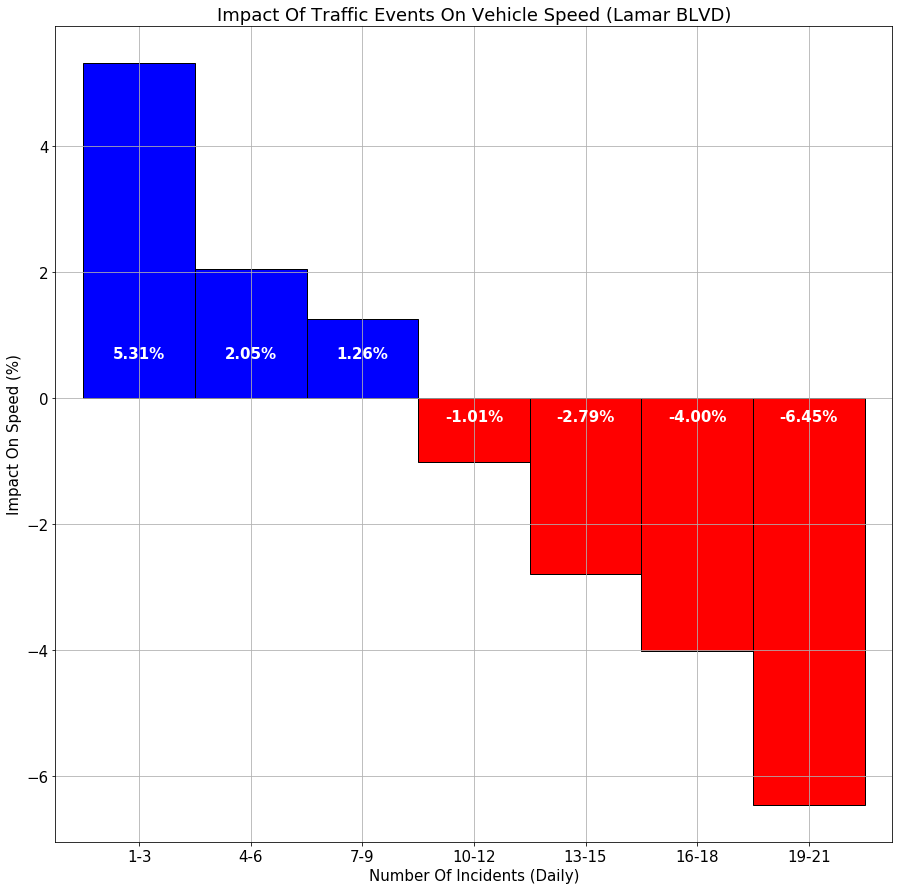

In [293]:
#plot data
mask = incident_vs_speed["Speed_Impact"] <= 0
colors = np.array(["b"] * len(incident_vs_speed["Speed_Impact"]))
colors[mask.values] = "r"
matplotlib.rcParams.update({'font.size': 15})
incidentplt = incident_vs_speed["Speed_Impact"].plot.bar(figsize = (15,15),color = colors,width = 1, edgecolor = "k", \
                               title = "Impact Of Traffic Events On Vehicle Speed (Lamar BLVD)",  \
                               grid = True)
autolabel(incidentplt.patches,incidentplt)
incidentplt.set(xlabel = "Number Of Incidents (Daily)", ylabel = "Impact On Speed (%)")
plt.xticks(rotation='horizontal')
plt.savefig("Images/incident_impact.png")
plt.show()